In [45]:
#导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
plt.style.use('seaborn')
np.random.seed(100)

In [71]:
#设置神经网络参数
station_id=1035#选择的监测站
lstm_units=16#lstm神经元个数
batch_size=64#批训练大小
epoch=100#迭代次数
test_ratio=.1#测试集比例
windows=5#时间窗
scale=1.0#归一化参数
save_model=('lstm-att-%d.h5'%station_id)#保存下该模型，便于下次加载
#读取数据
df=pd.read_csv('bjpm25.csv') 
df=df.iloc[:,:]
df.tail()

,station_id,time,PM25_Concentration,PM10_Concentration,NO2_Concentration,CO_Concentration,O3_Concentration,SO2_Concentration
164466,1036,2015/4/30 16:00,82,123.0,12.1,0.5,187.5,14.0
164467,1036,2015/4/30 17:00,81,87.1,11.1,0.5,192.3,16.6
164468,1036,2015/4/30 18:00,79,107.6,12.0,0.5,192.1,18.2
164469,1036,2015/4/30 19:00,77,104.6,15.5,0.5,180.7,18.3
164470,1036,2015/4/30 20:00,94,141.2,26.1,0.6,146.1,16.9


In [72]:
#筛选出当前station下的数据
df=df[df['station_id']==station_id]
df=df.iloc[:,2:]
df.tail()

,PM25_Concentration,PM10_Concentration,NO2_Concentration,CO_Concentration,O3_Concentration,SO2_Concentration
160762,78,97.8,64.4,0.8,173.6,11.7
160763,64,96.0,45.0,0.7,179.0,10.3
160764,69,140.2,28.2,0.7,171.8,8.5
160765,78,138.3,30.4,0.8,124.1,5.8
160766,94,128.4,24.9,1.0,148.6,9.1


In [73]:
#把数据处理成lstm接受的输入形式
y=df['PM25_Concentration']
data = np.array(df)/scale
cut = round(test_ratio* data.shape[0])
amount_of_features=data.shape[1]
lstm_input=[]
data_temp=data
for i in range(len(data_temp)-windows):
    lstm_input.append(data_temp[i:i+windows,:])
lstm_input=np.array(lstm_input)
#print(lstm_input.shape)
lstm_output=y[:-windows]
lstm_output=np.array(lstm_output)
#print(lstm_output.shape)
x_train,y_train,x_test,y_test=\
lstm_input[:-cut,:,:],lstm_output[:-cut:],lstm_input[-cut:,:,:],lstm_output[-cut:]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3654, 5, 6)
(407, 5, 6)
(3654,)
(407,)


In [74]:
#建立模型
inputs=Input(shape=(windows,amount_of_features))
lstm_inputs=Permute([2,1])(inputs)
lstm=LSTM(lstm_units,activation='relu', return_sequences=True)(lstm_inputs)
lstm=Permute([2,1])(lstm)#置换维度
lstm=Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(lstm)
attention=Dense(amount_of_features, activation='sigmoid', name='attention_vec')(lstm)#求解Attention权重
attention=Activation('softmax',name='attention_weight')(attention)
model=Multiply()([lstm, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='relu')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()#展示模型结构

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 5, 6)]       0                                            
__________________________________________________________________________________________________
permute_10 (Permute)            (None, 6, 5)         0           input_6[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 6, 16)        1408        permute_10[0][0]                 
__________________________________________________________________________________________________
permute_11 (Permute)            (None, 16, 6)        0           lstm_5[0][0]                     
______________________________________________________________________________________

In [75]:
'''
如果直接加载模型，则不需要运行这一段训练
'''
#训练模型
history=model.fit(x_train, y_train, epochs = epoch, batch_size = batch_size,
                  shuffle=False,validation_split=.1) #训练模型epoch次
model.save(save_model)#保存模型

Epoch 1/100
52/52 [==============================] - 0s 6ms/step - loss: 18865.0918 - accuracy: 0.0000e+00 - val_loss: 9189.5625 - val_accuracy: 0.0000e+00
Epoch 2/100
52/52 [==============================] - 0s 3ms/step - loss: 18585.4805 - accuracy: 0.0000e+00 - val_loss: 8918.0283 - val_accuracy: 0.0000e+00
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 17584.8906 - accuracy: 0.0000e+00 - val_loss: 7949.5532 - val_accuracy: 0.0000e+00
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 6730.7002 - accuracy: 0.0000e+00 - val_loss: 2582.2476 - val_accuracy: 0.0000e+00
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 2893.6785 - accuracy: 0.0000e+00 - val_loss: 1587.0033 - val_accuracy: 0.0000e+00
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 2220.4319 - accuracy: 0.0000e+00 - val_loss: 1767.8275 - val_accuracy: 0.0000e+00
Epoch 7/100
52/52 [==============================] - 0s 2ms/step - 

52/52 [==============================] - 0s 2ms/step - loss: 213.7133 - accuracy: 0.0000e+00 - val_loss: 513.2588 - val_accuracy: 0.0000e+00
Epoch 55/100
52/52 [==============================] - 0s 2ms/step - loss: 194.9582 - accuracy: 0.0000e+00 - val_loss: 514.1225 - val_accuracy: 0.0000e+00
Epoch 56/100
52/52 [==============================] - 0s 2ms/step - loss: 204.3272 - accuracy: 0.0000e+00 - val_loss: 486.3162 - val_accuracy: 0.0000e+00
Epoch 57/100
52/52 [==============================] - 0s 3ms/step - loss: 193.4297 - accuracy: 0.0000e+00 - val_loss: 457.2967 - val_accuracy: 0.0000e+00
Epoch 58/100
52/52 [==============================] - 0s 2ms/step - loss: 181.3664 - accuracy: 0.0000e+00 - val_loss: 453.2860 - val_accuracy: 0.0000e+00
Epoch 59/100
52/52 [==============================] - 0s 2ms/step - loss: 217.1401 - accuracy: 0.0000e+00 - val_loss: 558.2360 - val_accuracy: 0.0000e+00
Epoch 60/100
52/52 [==============================] - 0s 2ms/step - loss: 233.7190 - accu

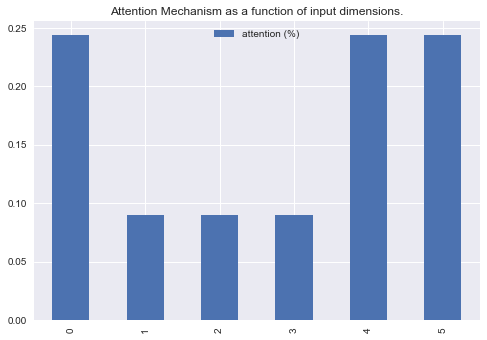

In [76]:
#加载模型
from tensorflow.keras.models import load_model
model=load_model(save_model)
#获得网络权重
#weights = np.array(model.get_weights())
#print(weights)
#输出attention层权重
attention_layer_model = Model(inputs=model.input,outputs=model.get_layer('attention_weight').output)
attention_weight = attention_layer_model.predict(x_train)
attention_weight_final=np.mean(np.array(attention_weight), axis=0)
pd.DataFrame(attention_weight_final, columns=['attention (%)']).plot(kind='bar',
                                                                         title='Attention Mechanism as '
                                                                               'a function of input'
                                                                               ' dimensions.')
plt.show()

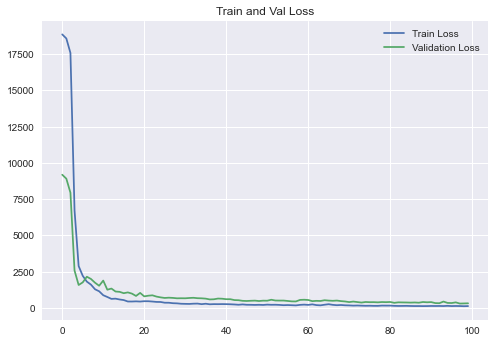

In [77]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

训练集上的MAE/RMSE/MAPE/涨跌准确率
7.565399707244535
11.795112684116665
14.052647557953474
0.7812756638379414


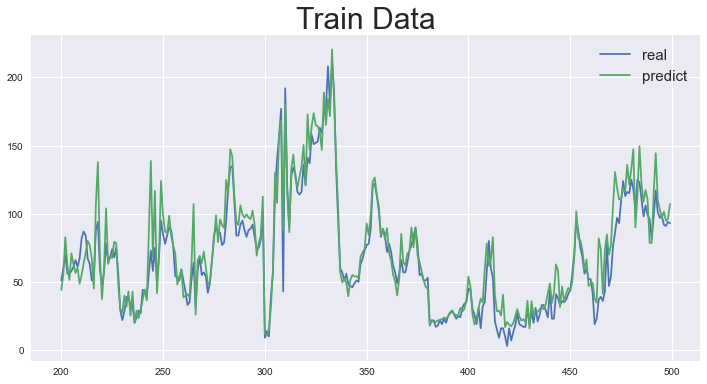

In [78]:
#模型进行检验
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
#在训练集上的拟合结果
y_train_predict=model.predict(x_train)*scale
y_train_predict=y_train_predict[:,0]
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#输出结果
print('训练集上的MAE/RMSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
print(np.sqrt(mean_squared_error(y_train_predict, y_train)))
print(mape(y_train_predict, y_train) )
print(up_down_accuracy(y_train_predict,y_train))

测试集上的MAE/RMSE/MAPE/涨跌准确率
8.26394595092286
12.78607221554969
11.36395165555698
0.7413793103448276


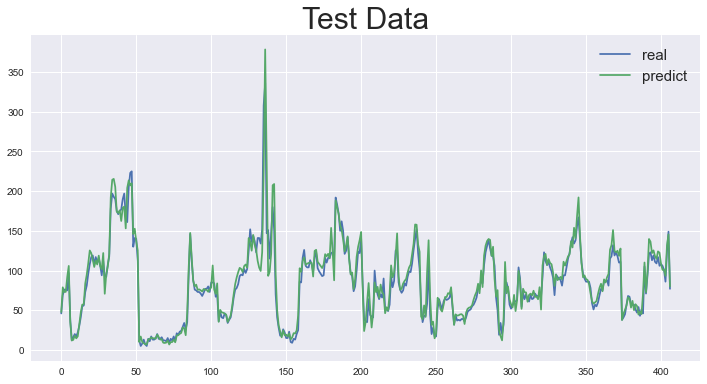

In [80]:
#在测试集上的预测
y_test_predict=model.predict(x_test)*scale
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
#输出结果
print('测试集上的MAE/RMSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(np.sqrt(mean_squared_error(y_test_predict, y_test)))
print(mape(y_test_predict,  y_test) )
print(up_down_accuracy(y_test_predict,y_test))